In [206]:
import numpy as np, pandas as pd
import sys, os, re, csv, codecs
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from tensorflow.keras.utils import to_categorical
from keras import initializers, regularizers, constraints, optimizers, layers
from sklearn import metrics
from sklearn import model_selection
import matplotlib.pyplot as plt
%matplotlib inline

In [207]:
train = pd.read_csv('tox_train.csv')
test = pd.read_csv('tox_test.csv')

In [208]:
train.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0


In [209]:
train.isnull().any(), test.isnull().any()

(id                 False
 target             False
 comment_text       False
 severe_toxicity    False
 obscene            False
 identity_attack    False
 insult             False
 threat             False
 dtype: bool,
 id              False
 comment_text    False
 dtype: bool)

/Users/dziuba/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


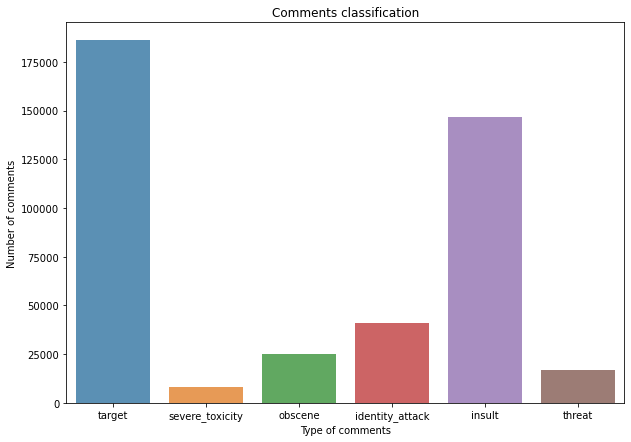

In [210]:
list_column = ["target","severe_toxicity","obscene","identity_attack", "insult", "threat" ]

counts = train[list_column].sum()
plt.figure(figsize=(10,7))
ax = sns.barplot(counts.index, counts.values, alpha=0.8)

plt.title("Comments classification")
plt.xlabel("Type of comments")
plt.ylabel("Number of comments")


plt.show()

In [211]:
def convert_to_binary(df, col_name):
    df[col_name] = np.where(df[col_name] >= 0.5, 1, 0)

In [212]:
train_df, validate_df = model_selection.train_test_split(train, test_size=0.2)
print('%d train comments, %d validate comments' % (len(train_df), len(validate_df)))


1443899 train comments, 360975 validate comments


In [213]:
MAX_FEATURES = 20000
TOXICITY_COLUMN = 'target'
TEXT_COLUMN = 'comment_text'

In [214]:
convert_to_binary(train_df, TOXICITY_COLUMN)
convert_to_binary(validate_df, TOXICITY_COLUMN)

train_df.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat
1265751,5661868,0,Something like shovelling liquid manure!,0.0,0.2,0.0,0.3,0.1
337749,656696,0,Thousands of native and non native vets are go...,0.0,0.0,0.0,0.0,0.0
529486,891157,0,"Yes, recent stress testing on new mortgage for...",0.0,0.0,0.0,0.0,0.0
258100,559484,0,While it's true that there have been a few cha...,0.0,0.0,0.0,0.0,0.0
154801,431440,0,PERS is a hideous mess to be sure. But what en...,0.0,0.0,0.0,0.2,0.0


In [215]:
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(train_df[TEXT_COLUMN])
train_tokenized_text = tokenizer.texts_to_sequences(train_df[TEXT_COLUMN])
train_labels = to_categorical(train_df[TOXICITY_COLUMN])
validate_tokenized_text = tokenizer.texts_to_sequences(validate_df[TEXT_COLUMN])
validate_labels = to_categorical(validate_df[TOXICITY_COLUMN])
test_text = tokenizer.texts_to_sequences(test[TEXT_COLUMN])

In [216]:
MAXLEN = 170
train_text = pad_sequences(train_tokenized_text, maxlen=MAXLEN )
validate_text = pad_sequences(validate_tokenized_text, maxlen=MAXLEN )
test_text = pad_sequences(test_text, maxlen=maxlen)

In [217]:
totalNumWords = [len(one_comment) for one_comment in train_tokenized_text]

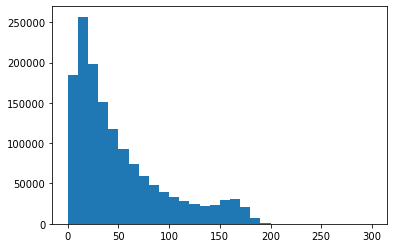

In [218]:
plt.hist(totalNumWords,bins = np.arange(0,310,10))
plt.show()

In [219]:
EMBED_SIZE = 128
x = Embedding(MAX_FEATURES, EMBED_SIZE)(inp)

In [220]:
x = LSTM(60, return_sequences=True, name='lstm_layer')(x)

In [221]:
x = GlobalMaxPool1D()(x)

In [222]:
x = Dropout(0.1)(x)

In [223]:
x = Dense(50, activation="relu")(x)

In [224]:
x = Dropout(0.1)(x) 

In [225]:
x = Dense(2, activation="sigmoid")(x)

In [226]:
model = Model(inputs=inp, outputs=x)
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 170)]             0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 170, 128)          2560000   
_________________________________________________________________
lstm_layer (LSTM)            (None, 170, 60)           45360     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 60)                0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 50)                3050      
_________________________________________________________________
dropout_10 (Dropout)         (None, 50)                0  

In [227]:
model.fit(train_text, train_labels, batch_size=128, epochs=2, validation_data=(validate_text, validate_labels))

Epoch 1/2
11281/11281 [==============================] - 13515s 1s/step - loss: 0.1481 - accuracy: 0.9455 - val_loss: 0.1307 - val_accuracy: 0.9500
Epoch 2/2
11281/11281 [==============================] - 5792s 513ms/step - loss: 0.1277 - accuracy: 0.9511 - val_loss: 0.1287 - val_accuracy: 0.9509


In [228]:
validate_pred = pd.DataFrame.from_dict({
    'id': validate_df.id,
    'prediction': model.predict(validate_text)[:,1]
})
validate_pred.head(5)

,id,prediction
1392280,5820062,0.788071
521755,882045,0.402944
881942,5199740,0.001373
1662832,6160376,0.001347
311921,624151,0.003013


In [229]:
submission = pd.DataFrame.from_dict({
    'id': test.id,
    'prediction': model.predict(test_text)[:,1]
})
submission.to_csv('submission.csv', index=False)